# Importing tools

In [9]:
# IMPORTANT: Execute the code step by step because it takes files from other Notebooks and creates Excel files that are stored in the same folder as this Notebook

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import file

In [11]:
df_id_clean = 'train_id_cleaned_pipeline_to_model.csv'

In [12]:
df_tr_clean = 'train_tr_cleaned_pipeline_to_model.csv'

In [13]:
df_id = pd.read_csv(df_id_clean)

In [14]:
df_tr = pd.read_csv(df_tr_clean)

In [15]:
df_id.shape

(144233, 56)

In [16]:
df_tr.shape

(590540, 353)

# Merged

In [21]:
df_merged = pd.merge(df_id, df_tr, on='TransactionID', how='left')

In [22]:
df_merged.shape

(144233, 408)

In [23]:
df_merged_fe = df_merged

In [24]:
if 'TransactionDT_datetime' in df_merged_fe.columns:
    df_merged_fe = df_merged_fe.drop(columns=['TransactionDT_datetime'])

# Model with Feature Engineering

Tipos de datos en X antes de entrenar:
id_01                        float64
id_02                        float64
id_03                        float64
id_04                        float64
id_05                        float64
                              ...   
TransactionAmt_High_card1      int64
C14_High                       int64
Transactions_Last_Day        float64
D8_minus_D1                  float64
V156_V166_Sum                float64
Length: 406, dtype: object
Columnas categóricas usadas: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo']
[LightGBM] [Info] Number of positive: 9054, number of negative: 106332
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34280
[LightGBM] [Info] Number of data points in the train set: 1

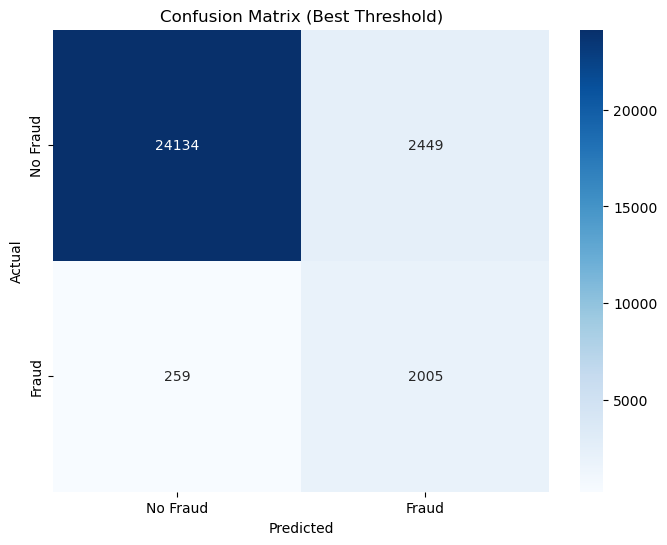

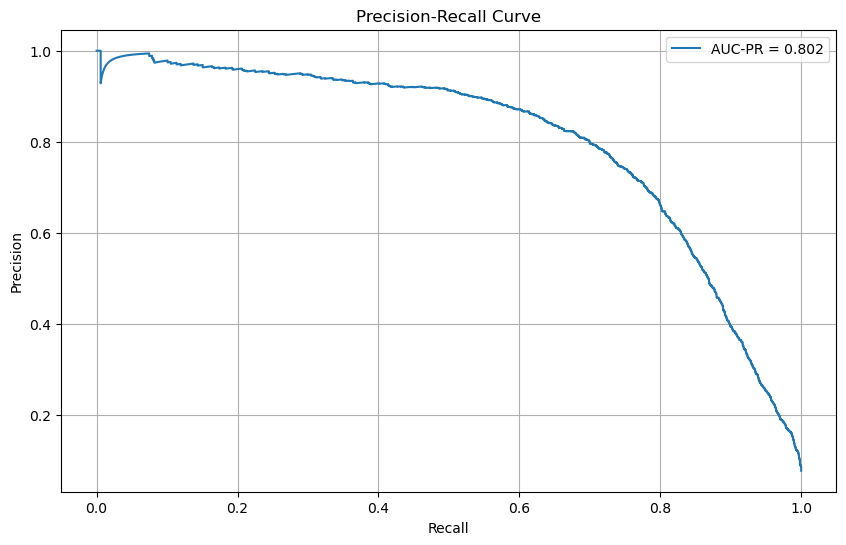

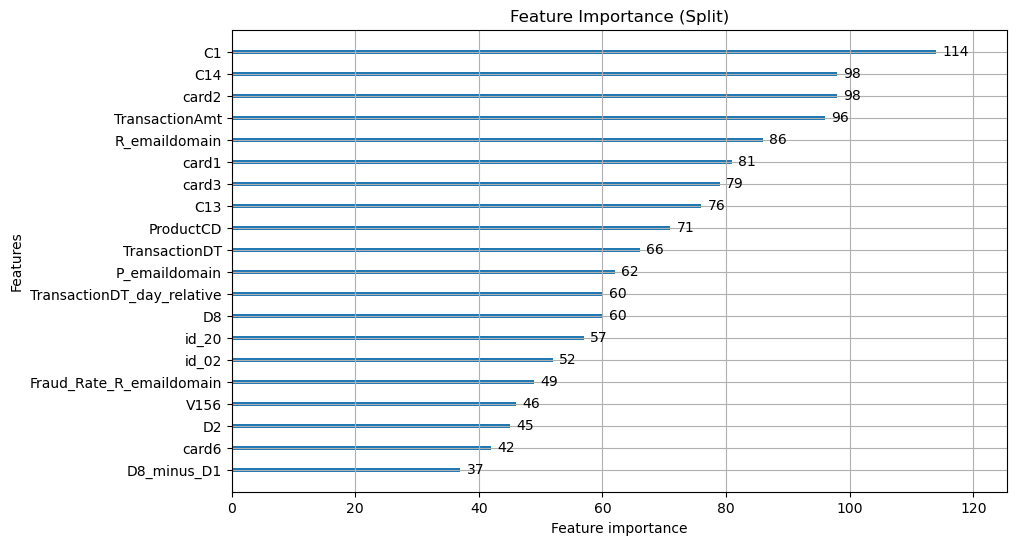

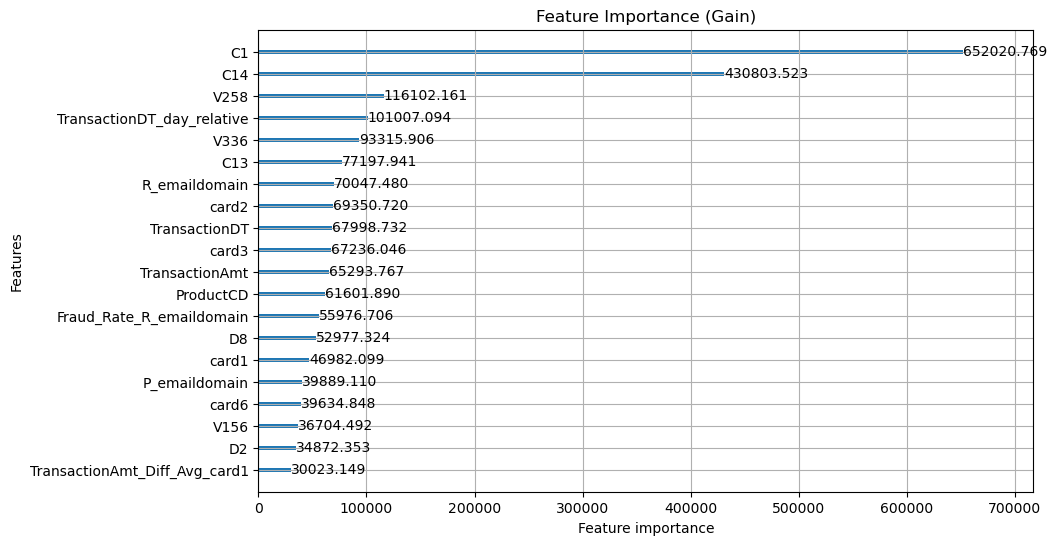


Modelo con nuevas características guardado como 'lightgbm_model_fe.txt'


In [25]:
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Seleccionar características
features = [col for col in df_merged_fe.columns if col not in ['TransactionID', 'isFraud']]
X = df_merged_fe[features]
y = df_merged_fe['isFraud']

# Verificar tipos de datos para asegurarnos de que no haya columnas incompatibles
print("Tipos de datos en X antes de entrenar:")
print(X.dtypes)

# Definir columnas categóricas (basadas en las transformaciones de TransactionCleaner e IdentityCleaner)
categorical_features = [
    'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',  # De TransactionCleaner
    'id_30', 'id_31', 'id_33', 'DeviceInfo'  # De IdentityCleaner (ajusta según las columnas que tengas)
    # Agrega cualquier otra columna categórica que hayas creado
]

# Asegurarse de que las columnas categóricas estén en X
categorical_features = [col for col in categorical_features if col in X.columns]
print("Columnas categóricas usadas:", categorical_features)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convertir a formato LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Configurar parámetros (mismos que antes)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': 60,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1
}

# Contador de tiempo
start_time = time.time()

# Entrenar el modelo con callback de early stopping y log de evaluación
model = lgb.train(params, train_data, num_boost_round=200,
                  valid_sets=[train_data, test_data], 
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                             lgb.log_evaluation(period=10)])

# Calcular tiempo transcurrido
end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

# Predecir probabilidades para ambos conjuntos
y_pred_proba_train = model.predict(X_train)
y_pred_proba_test = model.predict(X_test)

# Calcular métricas para el conjunto de entrenamiento
auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
auc_pr_train = auc(recall_train, precision_train)
print(f"\nMétricas en el conjunto de entrenamiento:")
print(f"AUC-ROC (train): {auc_roc_train:.6f}")
print(f"AUC-PR (train): {auc_pr_train:.6f}")

# Calcular métricas para el conjunto de prueba
auc_roc_test = roc_auc_score(y_test, y_pred_proba_test)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
auc_pr_test = auc(recall_test, precision_test)
print(f"\nMétricas en el conjunto de prueba:")
print(f"AUC-ROC (test): {auc_roc_test:.6f}")
print(f"AUC-PR (test): {auc_pr_test:.6f}")

# Encontrar el mejor umbral para maximizar el recall con una precision aceptable
thresholds = np.arange(0.1, 1.0, 0.05)
best_recall = 0
best_threshold_recall = 0
best_f1_recall = 0
best_precision_recall = 0
best_fpr_recall = 0
for threshold in thresholds:
    y_pred = (y_pred_proba_test >= threshold).astype(int)
    recall_val = recall_score(y_test, y_pred)
    precision_val = precision_score(y_test, y_pred, zero_division=0)
    f1_val = f1_score(y_test, y_pred)
    # Calcular FPR
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    # Priorizar recall, pero asegurar que precision no sea demasiado baja (e.g., >0.4)
    if recall_val > best_recall and precision_val > 0.4:
        best_recall = recall_val
        best_threshold_recall = threshold
        best_f1_recall = f1_val
        best_precision_recall = precision_val
        best_fpr_recall = fpr_val

print(f"\nMejor umbral para maximizar recall (con precision > 0.4): {best_threshold_recall:.2f}")
print(f"Métricas con umbral {best_threshold_recall:.2f} (en el conjunto de prueba):")
print(f"Recall: {best_recall:.6f}")
print(f"Precision: {best_precision_recall:.6f}")
print(f"F1-score: {best_f1_recall:.6f}")
print(f"FPR: {best_fpr_recall:.6f}")

# Validación cruzada para confirmar el rendimiento
print("\nRealizando validación cruzada (5-fold)...")
cv_results = lgb.cv(params, train_data, num_boost_round=200, nfold=5, 
                    metrics=['auc'],
                    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                               lgb.log_evaluation(period=10)])
print(f"CV AUC-ROC: {cv_results['valid auc-mean'][-1]:.6f} (+/- {cv_results['valid auc-stdv'][-1]:.6f})")

# Matriz de confusión para el mejor umbral
y_pred_best = (y_pred_proba_test >= best_threshold_recall).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Threshold)')
plt.show()

# Curva Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(recall_test, precision_test, label=f'AUC-PR = {auc_pr_test:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Visualizar importancia de características
lgb.plot_importance(model, max_num_features=20, importance_type='split', figsize=(10, 6))
plt.title("Feature Importance (Split)")
plt.show()
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (Gain)")
plt.show()

# Guardar el modelo
model.save_model('lightgbm_model_fe.txt')
print("\nModelo con nuevas características guardado como 'lightgbm_model_fe.txt'")

C:\Users\barba\AppData\Local\Temp\ipykernel_10248\264546633.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


Tipos de datos en X antes de entrenar:
id_01                        category
id_02                        category
id_03                         float64
id_04                        category
id_05                         float64
                               ...   
TransactionAmt_High_card1       int64
C14_High                        int64
Transactions_Last_Day         float64
D8_minus_D1                   float64
V156_V166_Sum                 float64
Length: 406, dtype: object
scale_pos_weight calculado: 11.74
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 9054, number of negative: 106332
[LightGBM] [Info] Total Bins 91694
[LightGBM] [Info] Number of data points in the train set: 115386, number of used features: 378
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

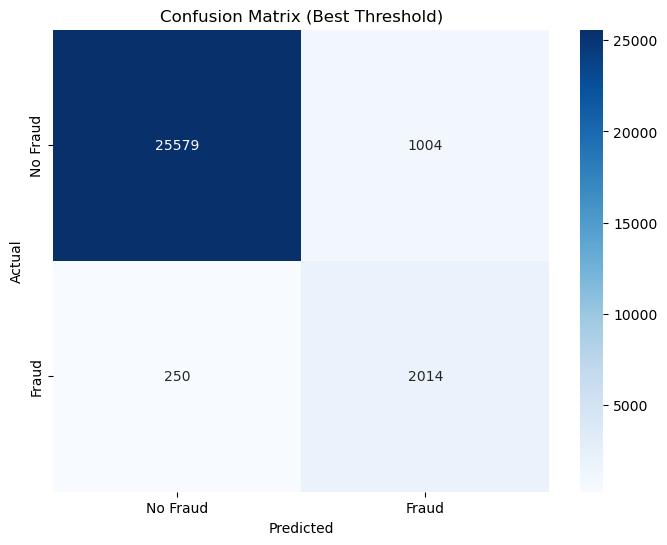

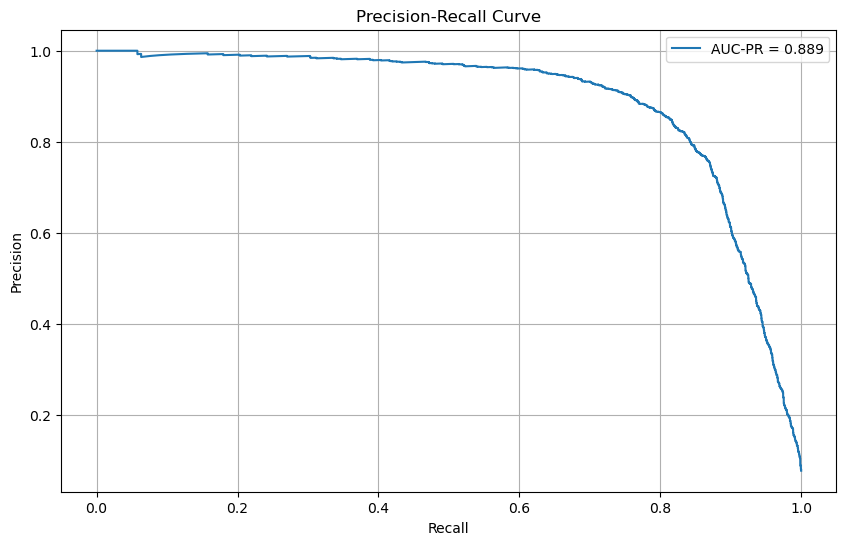

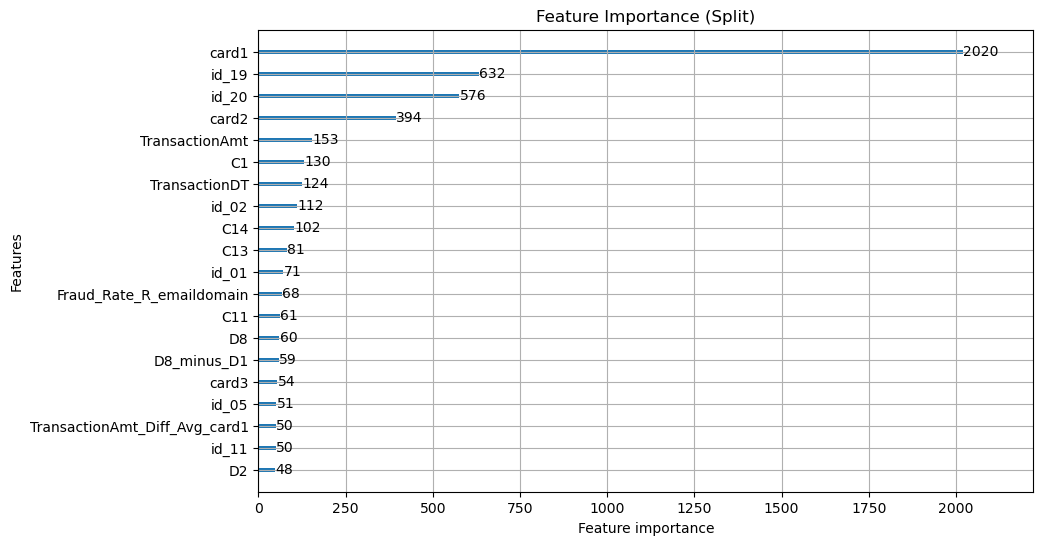

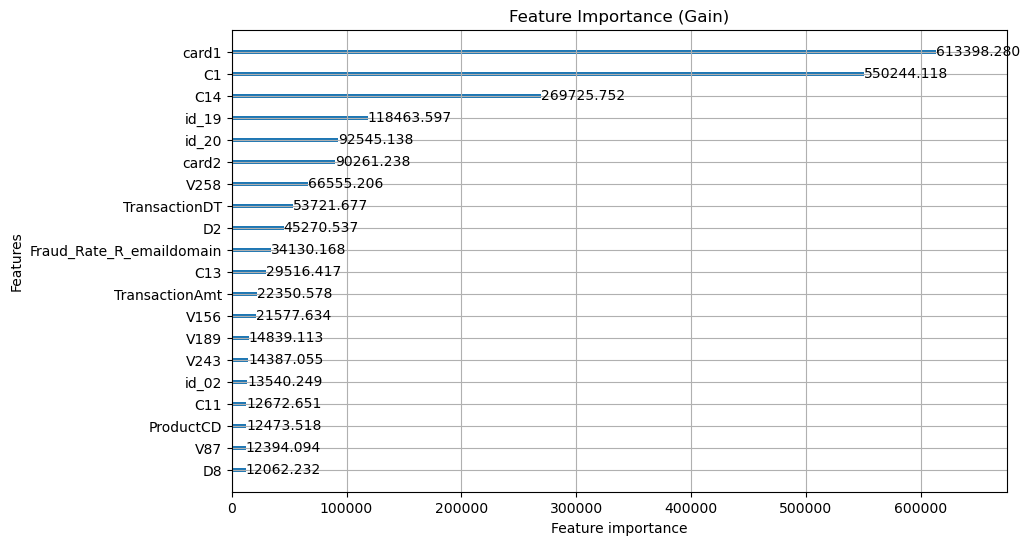


Modelo optimizado guardado como 'lightgbm_model_optimized.txt'


In [29]:
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Asumiendo que df_merged_fe ya está definido (resultado de unir df_id y df_tr)
# Seleccionar características
features = [col for col in df_merged_fe.columns if col not in ['TransactionID', 'isFraud']]
X = df_merged_fe[features]
y = df_merged_fe['isFraud']

# Definir columnas categóricas
categorical_features = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_01', 'id_02', 'id_04', 'id_11', 'id_12', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
    'id_20', 'id_22', 'id_23', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
    'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'
]

# Asegurarse de que las columnas categóricas estén en X y convertirlas a tipo category
categorical_features = [col for col in categorical_features if col in X.columns]
for col in categorical_features:
    X[col] = X[col].astype('category')

# Verificar tipos de datos para asegurarnos de que no haya columnas incompatibles
print("Tipos de datos en X antes de entrenar:")
print(X.dtypes)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convertir a formato LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Calcular el scale_pos_weight basado en el desbalance real
num_negatives = len(y_train[y_train == 0])
num_positives = len(y_train[y_train == 1])
scale_pos_weight = num_negatives / num_positives
print(f"scale_pos_weight calculado: {scale_pos_weight:.2f}")

# Configurar parámetros ajustados
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight,  # Ajustado al desbalance real
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'verbose': 1,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'force_row_wise': True,
    'max_bin': 1024  # Aumentado para manejar más categorías
}

# Contador de tiempo
start_time = time.time()

# Entrenar el modelo con callback de early stopping y log de evaluación
model = lgb.train(params, train_data, num_boost_round=500,
                  valid_sets=[train_data, test_data],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                             lgb.log_evaluation(period=10)])

# Calcular tiempo transcurrido
end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

# Predecir probabilidades para ambos conjuntos
y_pred_proba_train = model.predict(X_train)
y_pred_proba_test = model.predict(X_test)

# Calcular métricas para el conjunto de entrenamiento
auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
auc_pr_train = auc(recall_train, precision_train)
print(f"\nMétricas en el conjunto de entrenamiento:")
print(f"AUC-ROC (train): {auc_roc_train:.6f}")
print(f"AUC-PR (train): {auc_pr_train:.6f}")

# Calcular métricas para el conjunto de prueba
auc_roc_test = roc_auc_score(y_test, y_pred_proba_test)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
auc_pr_test = auc(recall_test, precision_test)
print(f"\nMétricas en el conjunto de prueba:")
print(f"AUC-ROC (test): {auc_roc_test:.6f}")
print(f"AUC-PR (test): {auc_pr_test:.6f}")

# Encontrar el mejor umbral para maximizar el recall con una precisión aceptable
thresholds = np.arange(0.5, 0.95, 0.01)
best_recall = 0
best_threshold_recall = 0
best_f1_recall = 0
best_precision_recall = 0
best_fpr_recall = 0
for threshold in thresholds:
    y_pred = (y_pred_proba_test >= threshold).astype(int)
    recall_val = recall_score(y_test, y_pred)
    precision_val = precision_score(y_test, y_pred, zero_division=0)
    f1_val = f1_score(y_test, y_pred)
    # Calcular FPR
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    # Priorizar recall, pero asegurar que precision sea > 0.4
    if recall_val > best_recall and precision_val > 0.4:
        best_recall = recall_val
        best_threshold_recall = threshold
        best_f1_recall = f1_val
        best_precision_recall = precision_val
        best_fpr_recall = fpr_val

print(f"\nMejor umbral para maximizar recall (con precision > 0.4): {best_threshold_recall:.2f}")
print(f"Métricas con umbral {best_threshold_recall:.2f} (en el conjunto de prueba):")
print(f"Recall: {best_recall:.6f}")
print(f"Precision: {best_precision_recall:.6f}")
print(f"F1-score: {best_f1_recall:.6f}")
print(f"FPR: {best_fpr_recall:.6f}")

# Validación cruzada para confirmar el rendimiento
print("\nRealizando validación cruzada (5-fold)...")
cv_results = lgb.cv(params, train_data, num_boost_round=500, nfold=5,
                    metrics=['auc'],
                    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                               lgb.log_evaluation(period=10)])
print(f"CV AUC-ROC: {cv_results['valid auc-mean'][-1]:.6f} (+/- {cv_results['valid auc-stdv'][-1]:.6f})")

# Matriz de confusión para el mejor umbral
y_pred_best = (y_pred_proba_test >= best_threshold_recall).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Threshold)')
plt.show()

# Curva Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(recall_test, precision_test, label=f'AUC-PR = {auc_pr_test:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Visualizar importancia de características
lgb.plot_importance(model, max_num_features=20, importance_type='split', figsize=(10, 6))
plt.title("Feature Importance (Split)")
plt.show()
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (Gain)")
plt.show()

# Guardar el modelo
model.save_model('lightgbm_model_optimized.txt')
print("\nModelo optimizado guardado como 'lightgbm_model_optimized.txt'")

In [25]:
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Asumiendo que df_merged_fe ya está definido
features = [col for col in df_merged_fe.columns if col not in ['TransactionID', 'isFraud']]
X = df_merged_fe[features]
y = df_merged_fe['isFraud']

categorical_features = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_01', 'id_02', 'id_04', 'id_11', 'id_12', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
    'id_20', 'id_22', 'id_23', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
    'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'
]
categorical_features = [col for col in categorical_features if col in X.columns]
for col in categorical_features:
    X[col] = X[col].astype('category')

print("Tipos de datos en X antes de entrenar:")
print(X.dtypes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

num_negatives = len(y_train[y_train == 0])
num_positives = len(y_train[y_train == 1])
scale_pos_weight = num_negatives / num_positives
print(f"scale_pos_weight calculado: {scale_pos_weight:.2f}")

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight * 1.5,
    'num_leaves': 20,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'force_row_wise': True,
    'max_bin': 1024,
    'num_boost_round': 600
}

start_time = time.time()
model = lgb.train(params, train_data, num_boost_round=600,
                  valid_sets=[train_data, test_data],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                             lgb.log_evaluation(period=10)])
end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

y_pred_proba_train = model.predict(X_train)
y_pred_proba_test = model.predict(X_test)

auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
auc_pr_train = auc(recall_train, precision_train)
print(f"\nMétricas en el conjunto de entrenamiento:")
print(f"AUC-ROC (train): {auc_roc_train:.6f}")
print(f"AUC-PR (train): {auc_pr_train:.6f}")

auc_roc_test = roc_auc_score(y_test, y_pred_proba_test)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
auc_pr_test = auc(recall_test, precision_test)
print(f"\nMétricas en el conjunto de prueba:")
print(f"AUC-ROC (test): {auc_roc_test:.6f}")
print(f"AUC-PR (test): {auc_pr_test:.6f}")

thresholds = np.arange(0.3, 0.6, 0.01)
best_recall = 0
best_threshold_recall = 0
best_f1_recall = 0
best_precision_recall = 0
best_fpr_recall = 0
for threshold in thresholds:
    y_pred = (y_pred_proba_test >= threshold).astype(int)
    recall_val = recall_score(y_test, y_pred)
    precision_val = precision_score(y_test, y_pred, zero_division=0)
    f1_val = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    if recall_val > best_recall and precision_val > 0.4:
        best_recall = recall_val
        best_threshold_recall = threshold
        best_f1_recall = f1_val
        best_precision_recall = precision_val
        best_fpr_recall = fpr_val

print(f"\nMejor umbral para maximizar recall (con precision > 0.4): {best_threshold_recall:.2f}")
print(f"Métricas con umbral {best_threshold_recall:.2f} (en el conjunto de prueba):")
print(f"Recall: {best_recall:.6f}")
print(f"Precision: {best_precision_recall:.6f}")
print(f"F1-score: {best_f1_recall:.6f}")
print(f"FPR: {best_fpr_recall:.6f}")

print("\nRealizando validación cruzada (5-fold)...")
cv_results = lgb.cv(params, train_data, num_boost_round=600, nfold=5,
                    metrics=['auc'],
                    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                               lgb.log_evaluation(period=10)])
print(f"CV AUC-ROC: {cv_results['valid auc-mean'][-1]:.6f} (+/- {cv_results['valid auc-stdv'][-1]:.6f})")

model.save_model('lightgbm_model_high_recall.txt')
print("\nModelo optimizado para recall guardado como 'lightgbm_model_high_recall.txt'")

C:\Users\barba\AppData\Local\Temp\ipykernel_3132\3512147091.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


Tipos de datos en X antes de entrenar:
id_01                        category
id_02                        category
id_03                         float64
id_04                        category
id_05                         float64
                               ...   
TransactionAmt_High_card1       int64
C14_High                        int64
Transactions_Last_Day         float64
D8_minus_D1                   float64
V156_V166_Sum                 float64
Length: 406, dtype: object
scale_pos_weight calculado: 11.74
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 9054, number of negative: 106332
[LightGBM] [Info] Total Bins 91694
[LightGBM] [Info] Number of data points in the train set: 115386, number of used features: 378
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

C:\Users\barba\AppData\Local\Temp\ipykernel_3132\1381064843.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


Tipos de datos en X antes de entrenar:
id_01                        category
id_02                        category
id_03                         float64
id_04                        category
id_05                         float64
                               ...   
TransactionAmt_High_card1       int64
C14_High                        int64
Transactions_Last_Day         float64
D8_minus_D1                   float64
V156_V166_Sum                 float64
Length: 406, dtype: object
scale_pos_weight calculado: 11.74
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 9054, number of negative: 106332
[LightGBM] [Info] Total Bins 91694
[LightGBM] [Info] Number of data points in the train set: 115386, number of used features: 378
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

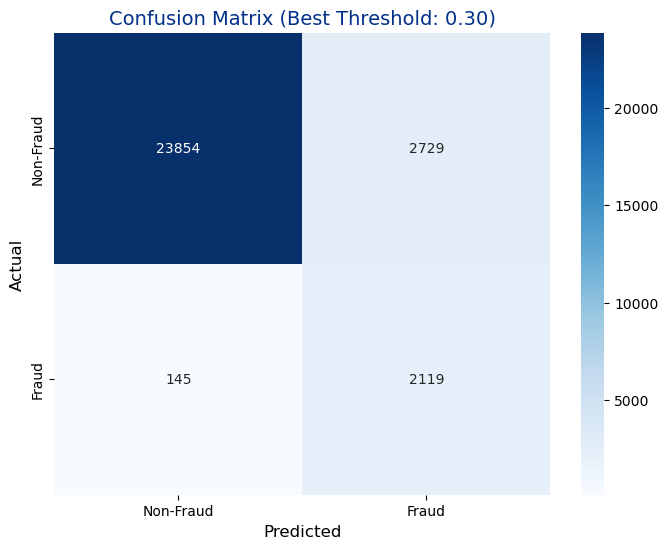

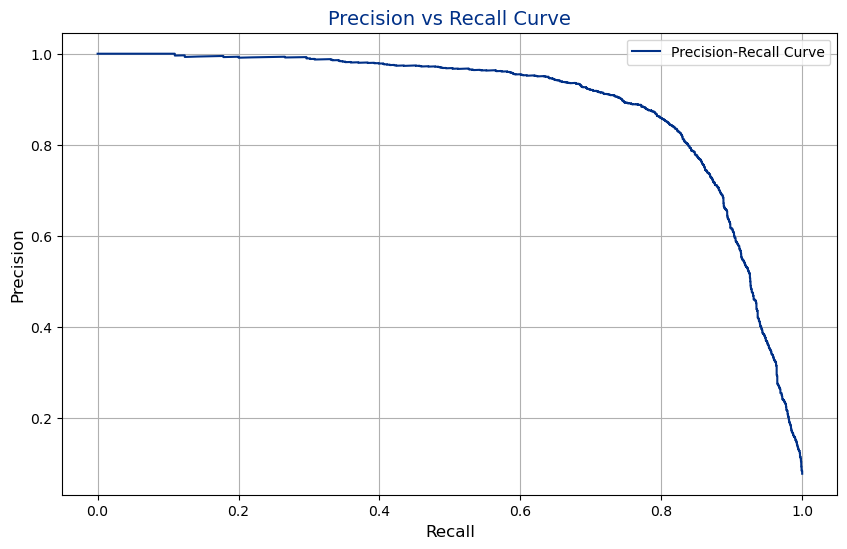

AttributeError: 'numpy.int32' object has no attribute 'get_text'

<Figure size 1000x600 with 0 Axes>

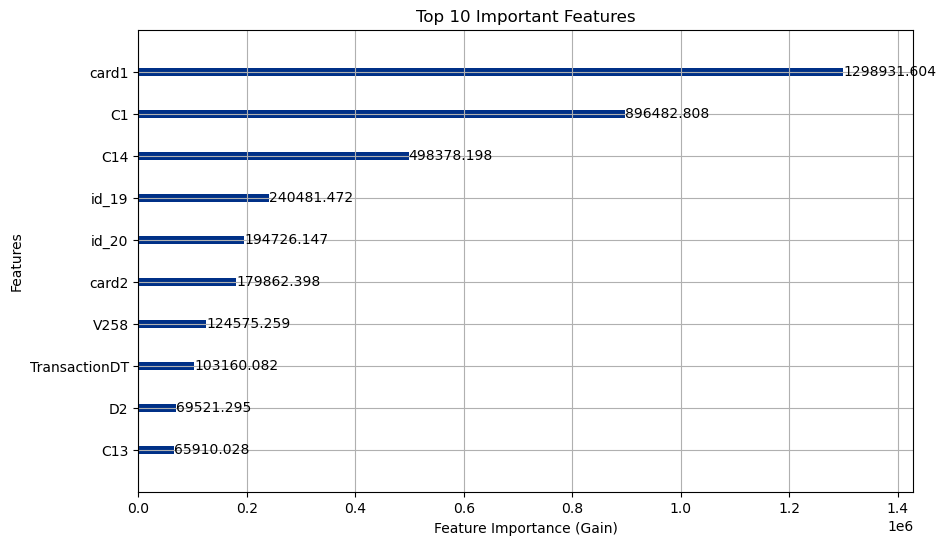

In [34]:
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Asumiendo que df_merged_fe ya está definido
features = [col for col in df_merged_fe.columns if col not in ['TransactionID', 'isFraud']]
X = df_merged_fe[features]
y = df_merged_fe['isFraud']

categorical_features = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_01', 'id_02', 'id_04', 'id_11', 'id_12', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
    'id_20', 'id_22', 'id_23', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
    'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'
]
categorical_features = [col for col in categorical_features if col in X.columns]
for col in categorical_features:
    X[col] = X[col].astype('category')

print("Tipos de datos en X antes de entrenar:")
print(X.dtypes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

num_negatives = len(y_train[y_train == 0])
num_positives = len(y_train[y_train == 1])
scale_pos_weight = num_negatives / num_positives
print(f"scale_pos_weight calculado: {scale_pos_weight:.2f}")

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight * 1.5,
    'num_leaves': 20,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'force_row_wise': True,
    'max_bin': 1024,
    'num_boost_round': 600
}

start_time = time.time()
model = lgb.train(params, train_data, num_boost_round=600,
                  valid_sets=[train_data, test_data],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                             lgb.log_evaluation(period=10)])
end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

y_pred_proba_train = model.predict(X_train)
y_pred_proba_test = model.predict(X_test)

auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
auc_pr_train = auc(recall_train, precision_train)
print(f"\nMétricas en el conjunto de entrenamiento:")
print(f"AUC-ROC (train): {auc_roc_train:.6f}")
print(f"AUC-PR (train): {auc_pr_train:.6f}")

auc_roc_test = roc_auc_score(y_test, y_pred_proba_test)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
auc_pr_test = auc(recall_test, precision_test)
print(f"\nMétricas en el conjunto de prueba:")
print(f"AUC-ROC (test): {auc_roc_test:.6f}")
print(f"AUC-PR (test): {auc_pr_test:.6f}")

thresholds = np.arange(0.3, 0.6, 0.01)
best_recall = 0
best_threshold_recall = 0
best_f1_recall = 0
best_precision_recall = 0
best_fpr_recall = 0
for threshold in thresholds:
    y_pred = (y_pred_proba_test >= threshold).astype(int)
    recall_val = recall_score(y_test, y_pred)
    precision_val = precision_score(y_test, y_pred, zero_division=0)
    f1_val = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0
    if recall_val > best_recall and precision_val > 0.4:
        best_recall = recall_val
        best_threshold_recall = threshold
        best_f1_recall = f1_val
        best_precision_recall = precision_val
        best_fpr_recall = fpr_val

print(f"\nMejor umbral para maximizar recall (con precision > 0.4): {best_threshold_recall:.2f}")
print(f"Métricas con umbral {best_threshold_recall:.2f} (en el conjunto de prueba):")
print(f"Recall: {best_recall:.6f}")
print(f"Precision: {best_precision_recall:.6f}")
print(f"F1-score: {best_f1_recall:.6f}")
print(f"FPR: {best_fpr_recall:.6f}")

print("\nRealizando validación cruzada (5-fold)...")
cv_results = lgb.cv(params, train_data, num_boost_round=600, nfold=5,
                    metrics=['auc'],
                    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=True),
                               lgb.log_evaluation(period=10)])
print(f"CV AUC-ROC: {cv_results['valid auc-mean'][-1]:.6f} (+/- {cv_results['valid auc-stdv'][-1]:.6f})")

# Guardar el modelo
model.save_model('lightgbm_model_high_recall.txt')
print("\nModelo optimizado para recall guardado como 'lightgbm_model_high_recall.txt'")

# Gráficos adicionales
# 1. Gráfico de Confusión
y_pred_best = (y_pred_proba_test >= best_threshold_recall).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix (Best Threshold: 0.30)', fontsize=14, color='#003087')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# 2. Gráfico de Precisión vs Recall
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve', color='#003087')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision vs Recall Curve', fontsize=14, color='#003087')
plt.grid()
plt.legend()
plt.show()

# 3. Gráfico de Columnas Más Importantes
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(10, 6), title='Top 10 Important Features', xlabel='Feature Importance (Gain)', color='#003087')
# Modificar nombres de las columnas (mayúsculas y sin guiones bajos)
plt.yticks(plt.yticks()[0], [label.get_text().upper().replace('_', '') for label in plt.yticks()[0]])
plt.title('Top 10 Important Features', fontsize=14, color='#003087')
plt.show()
